In [1]:
from sklearn.isotonic import IsotonicRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

df = pd.read_csv("processed/16.csv")
df.head()

,review_time,card_id,rating,review_state,is_learn_start,sequence_group,last_learn_start,mask,delta_t,i,delta_t_f,t_bin,t_history,r_history,t_f_history,y
0,1616653250934,1616653232673,1,0,True,1,1,True,0,1,0.00s,1.00,NaN,NaN,NaN,0
1,1616653268997,1616653232673,3,0,False,1,1,True,18,2,18.00s,14.76,0,1,0.00s,1
2,1616653289364,1616653232673,3,0,False,1,1,True,20,3,20.00s,14.76,"0,18","1,3","0.00s,18.00s",1
3,1616739450670,1616660331515,2,0,False,1,0,True,0,1,0.00s,1.00,NaN,NaN,NaN,1
4,1616758369765,1616660331515,2,0,False,1,0,True,18919,2,5.26h,17286.74,0,2,0.00s,1


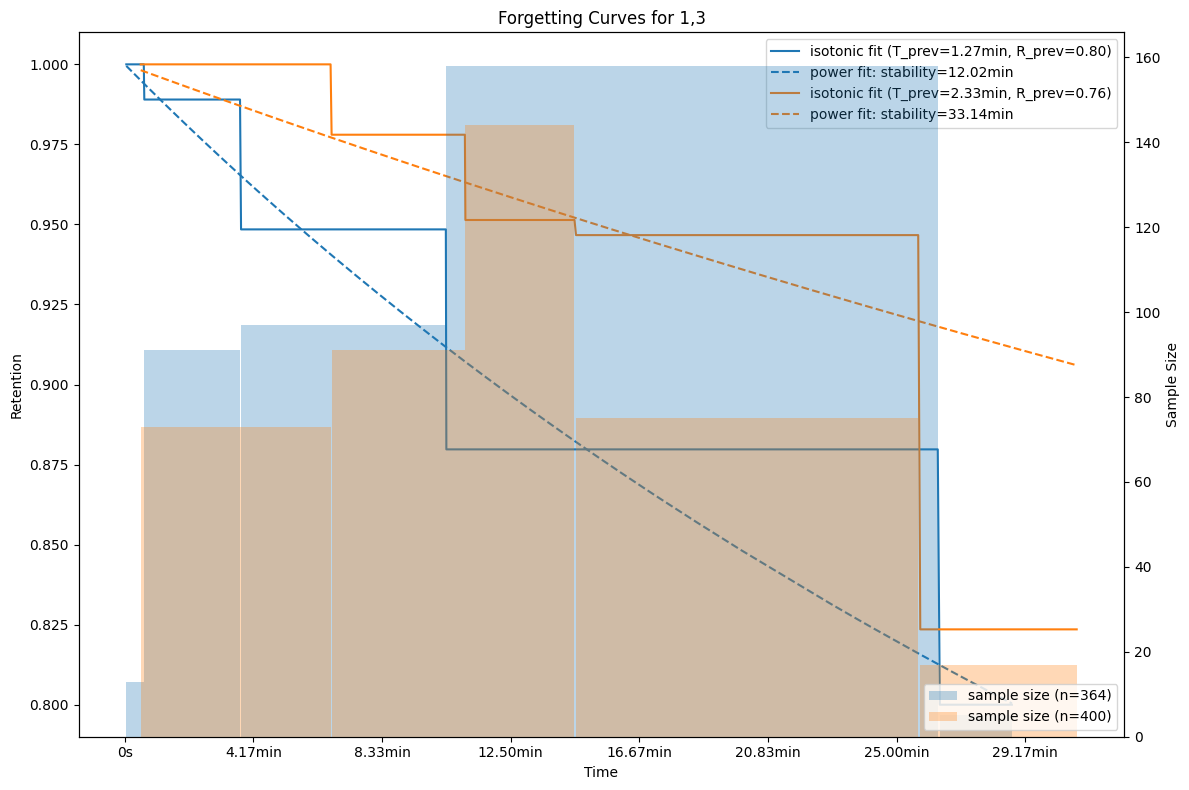

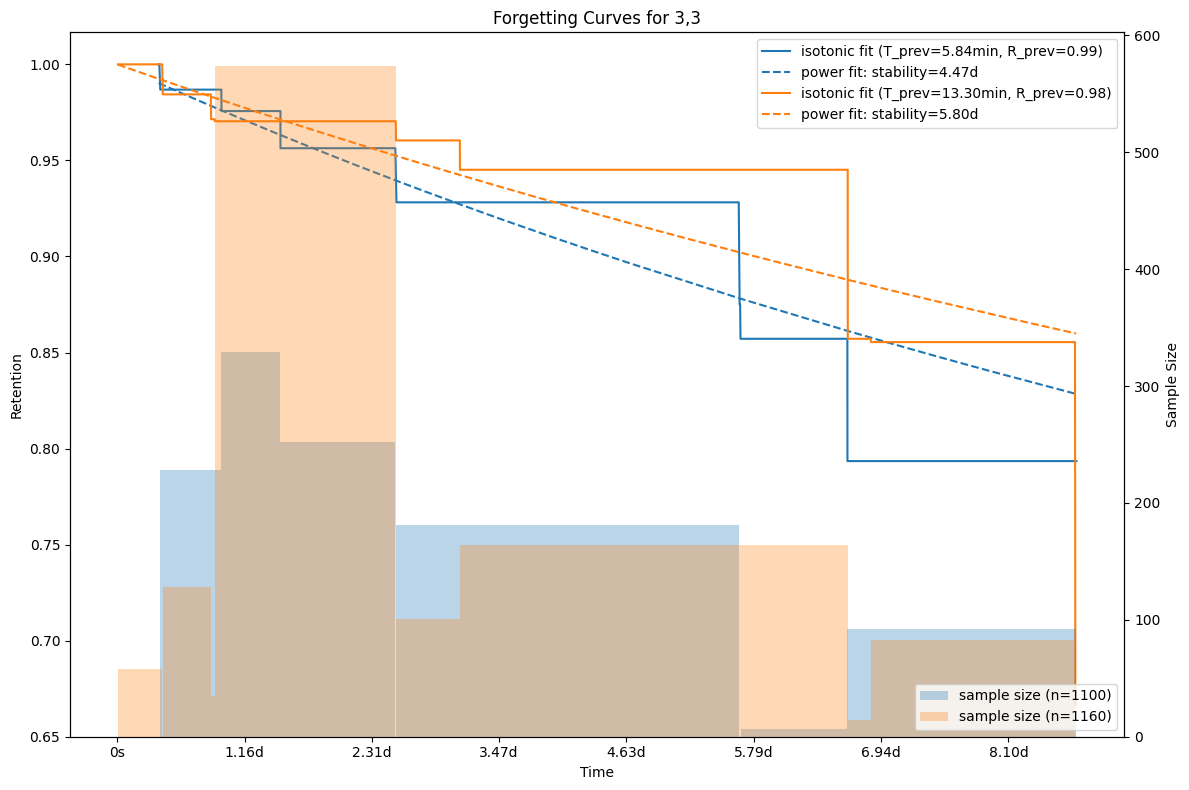

In [2]:
DECAY = -0.5


def power_forgetting_curve(t, s, decay=DECAY):
    factor = 0.9 ** (1 / decay) - 1
    return (1 + factor * t / s) ** decay


def fit_stability(delta_t, retention, size, decay=DECAY):

    def loss(stability):
        y_pred = power_forgetting_curve(delta_t, stability, decay)
        loss = sum(
            -(retention * np.log(y_pred) + (1 - retention) * np.log(1 - y_pred)) * size
        )
        return loss

    res = minimize(loss, x0=1, bounds=[(0.1, None)])
    return res.x[0]


def format_time(x, pos):
    if x < 60:
        return f"{x:.0f}s"
    elif x < 3600:
        return f"{x/60:.2f}min"
    elif x < 86400:
        return f"{x/3600:.2f}h"
    else:
        return f"{x/86400:.2f}d"
    

def filter_data(data):
    Q1 = data["delta_t"].quantile(0.25)
    Q3 = data["delta_t"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[
        (data["delta_t"] >= lower_bound) & (data["delta_t"] <= upper_bound)
    ]
    return data

r_history_list = ["1,3", "3,3"]


for r_history in r_history_list:

    fig, ax1 = plt.subplots(figsize=(12, 8))
    data = df[df["r_history"] == r_history][["delta_t", "y", "t_history"]]
    data = filter_data(data)
    
    if len(r_history) > 1:
        previous_data = df[df["r_history"] == r_history[:-2]]
        previous_data = filter_data(previous_data)
        median_interval = previous_data["delta_t"].median()
        data["prev_interval"] = data["t_history"].apply(lambda x: [float(i) for i in x.split(",")][-1])
        data_short = data[data["prev_interval"] <= median_interval]
        data_long = data[data["prev_interval"] > median_interval]
        median_short_interval = previous_data[previous_data["delta_t"] <= median_interval]["delta_t"].median()
        median_long_interval = previous_data[previous_data["delta_t"] > median_interval]["delta_t"].median()
        avg_short_retention = previous_data[previous_data["delta_t"] <= median_interval]["y"].mean()
        avg_long_retention = previous_data[previous_data["delta_t"] > median_interval]["y"].mean()

        datasets = [data_short, data_long]
        labels = [f"(T_prev={format_time(median_short_interval, None)}, R_prev={avg_short_retention:.2f})", f"(T_prev={format_time(median_long_interval, None)}, R_prev={avg_long_retention:.2f})"]
    else:
        datasets = [data]
        labels = [r_history]
    
    ax2 = ax1.twinx()
    for idx, dataset in enumerate(datasets):
        x, y = dataset.sort_values(by="delta_t")[["delta_t", "y"]].values.T

        ir = IsotonicRegression(y_min=0, y_max=1, increasing=False)
        ir.fit(x, y)
        y_ir = ir.predict(x)

        s_seconds = fit_stability(x, y_ir, np.ones_like(x))
        y_pred = power_forgetting_curve(x, s_seconds)
        cnt = len(x)

        ax1.plot(x, y_ir, '-', label=f"isotonic fit {labels[idx]}", color=f"C{idx}")
        ax1.plot(x, y_pred, '--', label=f"power fit: stability={format_time(s_seconds, None)}", color=f"C{idx}")

        unique_y_ir = np.unique(y_ir)
        segment_counts = []
        segment_x = []
        segment_widths = []
        for i in range(len(unique_y_ir)):
            mask = y_ir == unique_y_ir[i]
            segment_counts.append(np.sum(mask))
            segment_x.append(np.min(x[mask]))
            segment_widths.append(np.max(x[mask]) - np.min(x[mask]))

        ax2.bar(
            segment_x,
            segment_counts,
            alpha=0.3,
            width=segment_widths,
            color=f"C{idx}",
            label=f"sample size (n={cnt})",
            align="edge",
        )


    ax1.set_xlabel("Time")
    ax1.set_ylabel("Retention")
    ax2.set_ylabel("Sample Size")
    ax1.legend(loc="upper right")
    ax2.legend(loc="lower right")
    ax1.set_title(f"Forgetting Curves for {r_history}")

    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_time))

    plt.tight_layout()
    plt.show()
